# IMDB with tf.Keras and TPU 20181202

## 1. Obtain IMDB dataset

In [1]:
import numpy as np
import six
import tensorflow as tf
import time
import os

print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [2]:
max_features = 10000  # number of words to consider as features
SEQ_LEN=500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=SEQ_LEN)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=SEQ_LEN)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [0]:
x_test=x_train[20000:25000]
y_test=y_train[20000:25000]

In [0]:
x_train=x_train[0:20000]
y_train=y_train[0:20000]

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 500)
(20000,)
(5000, 500)
(5000,)


## 2.Build the model

The model is defined as a two-layer, forward-LSTM—with two changes from the `tf.keras` standard LSTM definition:

1. Define the input `shape` of our model which satisfies the [XLA compiler](https://www.tensorflow.org/performance/xla/)'s static shape requirement.
2. Use `tf.train.Optimizer` instead of a standard Keras optimizer (Keras optimizer support is still experimental).

In [0]:
BATCH_SIZE = 1024
EPOCHS = 20

EMBEDDING_DIM = 64

In [0]:
def model(seq_len=BATCH_SIZE, batch_size=None, stateful=False):
  
  source = tf.keras.Input(
      name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

  embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=EMBEDDING_DIM)(source)
  lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=False)(embedding)
  #lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=False)(lstm_1)
  predicted_char = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_1)
  model = tf.keras.Model(inputs=[source], outputs=[predicted_char])
  
  return model

In [0]:
model = model(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, stateful=False)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (1024, 500)               0         
_________________________________________________________________
embedding (Embedding)        (1024, 500, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (1024, 64)                33024     
_________________________________________________________________
dense (Dense)                (1024, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


## 3.Train the model

The `tf.contrib.tpu.keras_to_tpu_model` function converts a `tf.keras` model to an equivalent TPU version. We then use the standard Keras methods to train: `fit`, `predict`, and `evaluate`.

In [10]:
strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.100.206.122:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 18328243821621706652)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8308018315895512029)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9214228356634114571)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17605395658903627103)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10022652993088569534)
INFO:tensorflow:*** Available Device: _Dev

In [0]:
   model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss='binary_crossentropy',
      metrics=['accuracy'])  


In [12]:
from tensorflow.keras.callbacks import History
history = History()

%time model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,  callbacks=[history], validation_data=(x_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 500), dtype=tf.int32, name='seed_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for seed
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.528717041015625 secs
INFO:tensorflow:Setting weights on TPU model.
18432/20000 [==========================>...] - ETA: 0s - loss: 0.6931 - acc: 0.5021INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(68,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(68, 500), dtype=tf.int32, name='seed_10'), TensorSpec(shape=(68, 1), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping 

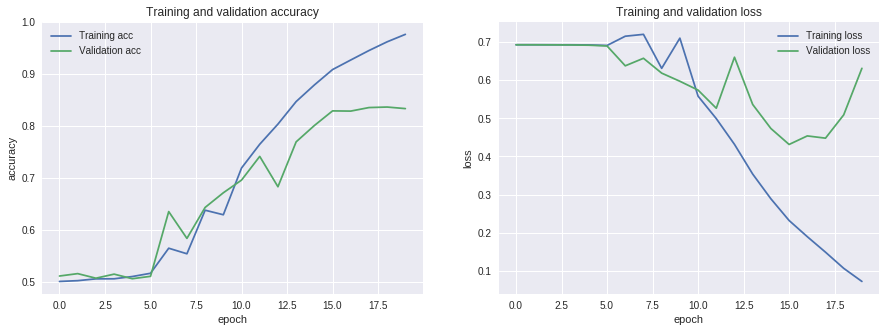

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()